### upflit моделирование

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.options.display.max_columns = 150
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv(r"C:\Users\nikita.saprykin\Desktop\Машинное обучение в бизнесе\lection4_materials\data.csv")

In [3]:
df.sample(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
41555,2,363.58,0,1,Rural,0,Web,Discount,1
40650,1,1916.16,1,0,Surburban,1,Multichannel,No Offer,1
13580,9,328.76,1,0,Surburban,1,Phone,Buy One Get One,0
53158,2,469.40,0,1,Urban,0,Web,Discount,0
6184,2,133.37,1,0,Surburban,1,Phone,No Offer,0


В данном примере поле conversion говорит о результате воздействия на клиента, была ли обратная реакция. 
Поле offer говорит о том было ли направлено воздействие на клиента или нет. То есть в offer говориться о
предложении скидки или рекламной акции BOGO (Buy One Get One), а в поле conversion говорится о том что
предложение было сделано, и результат конвертации (купить или нет). 

In [4]:
df = df.rename(columns={'offer':'treatment','conversion':'target'})
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [5]:
df.loc[(df['treatment'].isin(['Buy One Get One','Discount'])),'treatment'] = 1
df.loc[(df['treatment'].isin(['No Offer'])),'treatment'] = 0
df.sample(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
27076,2,429.70,0,1,Rural,0,Web,0,1
10000,10,296.28,0,1,Surburban,0,Web,1,0
31053,2,29.99,1,0,Surburban,1,Web,1,0
43856,9,29.99,0,1,Surburban,0,Phone,1,0
60122,12,80.94,1,0,Urban,1,Web,1,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df['target'], test_size=0.25, random_state = 1)

#### Одна модель с признаком коммуникации

In [7]:
treat_learn = X_train.loc[:, 'treatment']
treat_valid = X_test.loc[:, 'treatment']
treat_train_full = df.loc[:, 'treatment']
categorial_features = ['channel', 'zip_code']
models_results = {
    'approach': [],
    'uplift@30%': []
}
X_train.drop('treatment', 1, inplace = True)
X_test.drop('treatment', 1, inplace = True)

uplift@30%: 0.1033


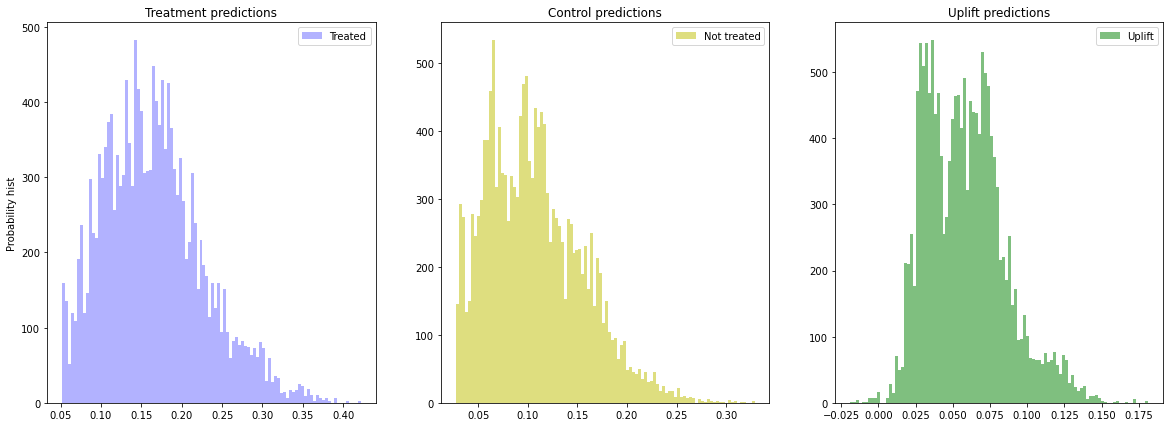

In [9]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_learn, estimator_fit_params={'cat_features': categorial_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

#### Трансформация классов

In [13]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_learn, estimator_fit_params={'cat_features': categorial_features})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

<ipython-input-13-05ec9938f3ed>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_learn, estimator_fit_params={'cat_features': categorial_features})


#### Две независимые модели

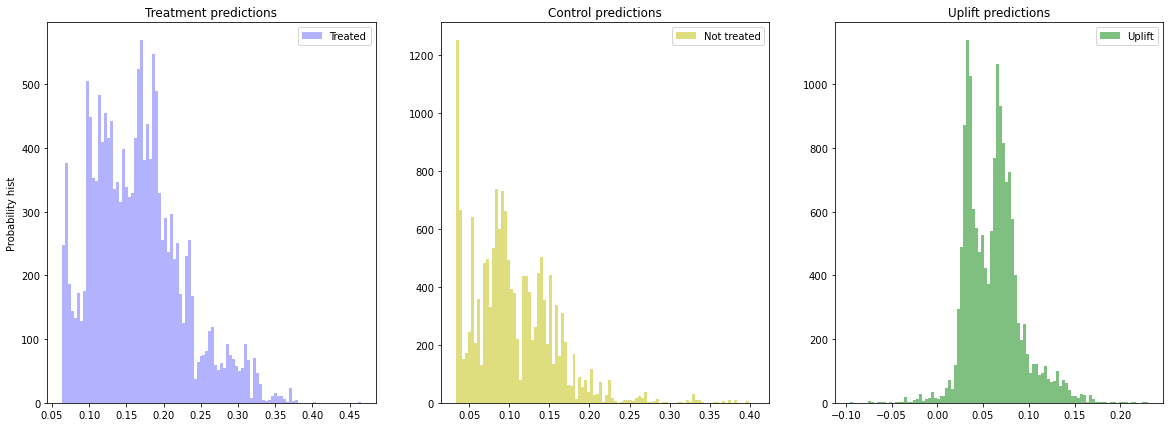

In [15]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_learn,
    estimator_trmnt_fit_params={'cat_features': categorial_features}, 
    estimator_ctrl_fit_params={'cat_features': categorial_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [16]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.103348
2,TwoModels,0.088339
1,ClassTransformation,0.077094
